In [4]:
import fiftyone as fo
import fiftyone.zoo as foz
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import openimages.download as oi
import os
import shutil
import random
from torchmetrics.classification import ConfusionMatrix
from torchmetrics import Accuracy, Precision, Recall, F1Score
from sklearn.model_selection import train_test_split

In [6]:
def download_images(images_path, classes):
    image_class_idx = []
    image_paths = []
    limit = 333

    if os.path.exists(images_path):
      shutil.rmtree(images_path)

    os.makedirs(images_path, exist_ok=True)

    for class_name in classes:
        print(f"Downloading images for class: {class_name}")

        images = oi.download_dataset(
            dest_dir = images_path,
            class_labels = [class_name],
            limit=limit
        )

        image_class_idx.extend([classes.index(class_name)] * limit)

        class_folder = os.path.join(images_path, class_name.lower(), 'images')

        for image_filename in os.listdir(class_folder):
          if image_filename.endswith('.jpg'):
            image_paths.append(os.path.join(class_folder, image_filename))

    return image_paths, image_class_idx

In [7]:
class OpenImagesDataset(Dataset):
    def __init__(self, image_paths, label_indexes, transform):
        self.image_paths = image_paths
        self.label_indexes = label_indexes
        self.num_of_classes = len(set(label_indexes))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_index = self.label_indexes[idx]

        image = Image.open(img_path).convert('RGB')
        transformed_image = self.transform(image)

        class_one_hot = torch.zeros(self.num_of_classes)
        class_one_hot[label_index] = 1

        return transformed_image, class_one_hot

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        return self.conv_stack(x)

In [9]:
def train_model(model, train_loader, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        acc_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            acc_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {acc_loss / len(train_loader)}')

In [10]:
def calculate_metrics(all_preds, all_labels, classes):
    num_of_labels = len(classes)
    accuracy_metric = Accuracy(task="multiclass", num_classes=num_of_labels, average='weighted')
    precision_metric = Precision(task="multiclass", num_classes=num_of_labels, average='weighted')
    recall_metric = Recall(task="multiclass", num_classes=num_of_labels, average='weighted')
    f1_metric = F1Score(task="multiclass", num_classes=num_of_labels, average='weighted')
    conf_matrix_metric = ConfusionMatrix(task="multiclass", num_classes=num_of_labels)

    accuracy = accuracy_metric(all_preds, all_labels)
    precision = precision_metric(all_preds, all_labels)
    recall = recall_metric(all_preds, all_labels)
    f1 = f1_metric(all_preds, all_labels)
    conf_matrix = conf_matrix_metric(all_preds, all_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    conf_matrix = conf_matrix_metric(all_preds, all_labels).cpu().numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [11]:
def evaluate(model, data_loader, classes, device):
    all_preds = []
    all_labels = []
    model.eval()

    with torch.inference_mode():
        for image_batch, img_labels in data_loader:
            image_batch = image_batch.to(device)
            img_labels = img_labels.to(device)

            outputs = model(image_batch)

            _, predicted_outputs = torch.max(outputs, 1)
            _, true_labels = torch.max(img_labels, 1)

            all_preds.append(predicted_outputs)
            all_labels.append(true_labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    calculate_metrics(all_preds, all_labels, classes)


In [12]:
classes = ["Car",
           "Tree",
           "Sink"]
images_path = "open_images"

transformTrain = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

transformTest = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [14]:
image_paths, image_labels = download_images(images_path, classes)

2025-03-26  22:37:48 INFO Downloading 333 train images for class 'car'
100%|██████████| 333/333 [00:16<00:00, 20.73it/s]


2025-03-26  22:39:24 INFO Downloading 333 train images for class 'tree'
100%|██████████| 333/333 [00:18<00:00, 17.82it/s]


2025-03-26  22:40:53 INFO Downloading 333 train images for class 'sink'
100%|██████████| 333/333 [00:15<00:00, 20.83it/s]


In [15]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.2, shuffle=True, stratify=image_labels
)

train_dataset = OpenImagesDataset(train_paths, train_labels, transformTrain)
test_dataset = OpenImagesDataset(test_paths, test_labels, transformTest)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork()
model = model.to(device)

train_model(model, train_loader, device)

Epoch 1/10, Loss: 1.097667179107666
Epoch 2/10, Loss: 1.0852877759933472
Epoch 3/10, Loss: 1.0631787967681885
Epoch 4/10, Loss: 1.0360298085212707
Epoch 5/10, Loss: 1.011201069355011
Epoch 6/10, Loss: 0.9836523532867432
Epoch 7/10, Loss: 0.9867636322975158
Epoch 8/10, Loss: 0.985729808807373
Epoch 9/10, Loss: 0.9299723362922668
Epoch 10/10, Loss: 0.8894350099563598


Accuracy: 0.5500
Precision: 0.5291
Recall: 0.5500
F1 Score: 0.5110
Confusion Matrix:
tensor([[46,  8, 12],
        [31, 12, 24],
        [ 9,  6, 52]])


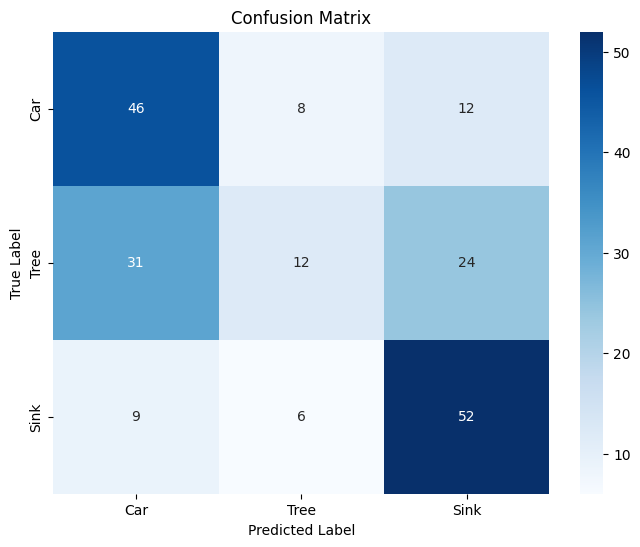

In [29]:
evaluate(model, test_loader, classes, device)

In [30]:
model_save_path = "trained_model.pth"
torch.save(model.state_dict(), model_save_path)